<center>
<h1>  </h1>
<h2> Example of DB_Maiz_phenology_SMFS </h2>
</center>
<h2> Contains:</h2>


1. What is SMFS?
2. Prerequisites
3. Reading image using GDAL
4. Showing our interesting area by Matplotlib
5. Preparing shape model
6. Vegetation timeseries preprocessing
7. Phenology detection

## 1. What is SMFS?

The SMFS method is a imporved shape model fitting based phenology detection algorithms.

In this example, we will guide step by step how to complete the phenology monitoring of an area through the SMFS algorithm. and how to change the window size to deal with noise.

## 2. Prerequisites

The following libraries are required to run the SMFS algorithm
* Numpy
* Numba

The following libraries are required to complete the entire notebook process
* GDAL python
* Scipy
* Matplotlib

## 3. Reading image using GDAL

<h>First, we use the gdal library to import a test NDVI (Normalized Difference Vegetation Index) image. The image is located in an area of ​​Baicheng City, Jilin Province. The main crop in the area is corn. The image has a spatial and temporal resolution of 500m and a temporal resolution of 8 days, starting on August 1, 2007 and ending on August 1, 2008. </h>

<h>We also imported the maize classification mapping data of the corresponding year.</h>

In [1]:
from osgeo import gdal
import os
os.chdir(r"D:\DB_Maiz_phenology_SMF_S\DB_Maize_Phenology_SMF_S\data")
dts = gdal.Open("BCROI")
# get geographic coordinates
# 打开文件以识别其类型
dataset = gdal.Open("BCROI")

proj, geot = dts.GetProjection(), dts.GetGeoTransform()
# get winter wheat cover image
img_cover = dts.ReadAsArray()
# get EVI time series image
img_evi_ts = gdal.Open("BCNDVI_2007").ReadAsArray()
print(img_cover.shape)
print(img_evi_ts.shape)
# for i in range(400):
#     for j in range(400):
#         if img_cover[i][j] == 0:
#             print(i,j)
#             print(img_cover[i][j])
#         else:
#             continue

(156, 156)
(46, 156, 157)


In [2]:
print(img_cover)
# print(img_evi_ts1[:,50, 51])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 1]
 [0 0 0 ... 1 1 1]]


We can simply use matplotlib to initially show the area where we want to monitor phenology. And plot out some winter Maize NDVI curves.

In [3]:
from random import randint
def random_a_point():
    while True:
        x, y = randint(0, 156), randint(0, 157)
        if img_cover[x, y] == 1:
            return x, y

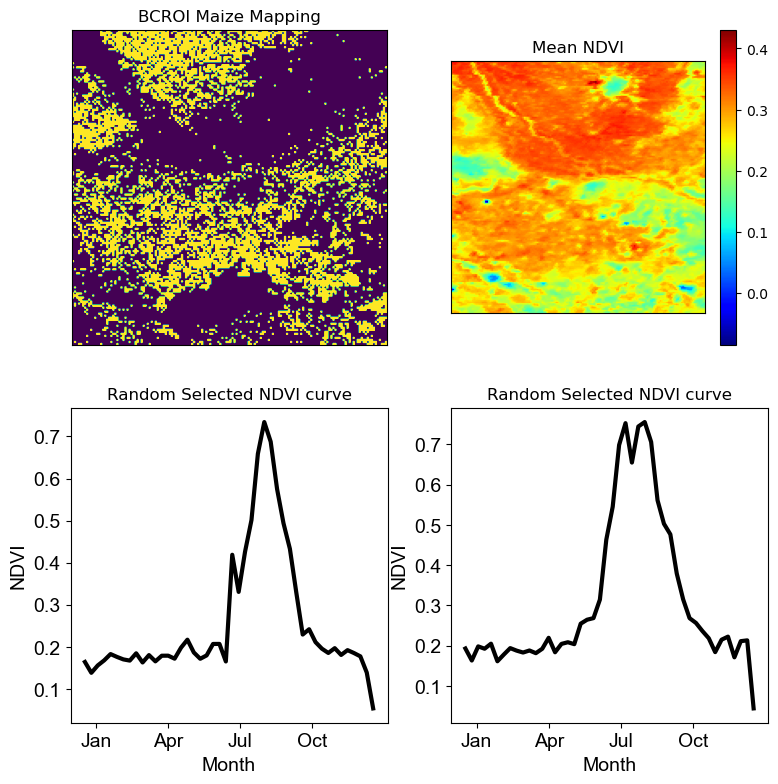

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
ticks_font = FontProperties(fname="C:\\Windows\\Fonts\\arial.ttf", size=14)

DOYs = np.arange(1, 366, 8)

plt.figure(figsize=(9, 9))

plt.subplot(221)
plt.title("BCROI Maize Mapping")
plt.imshow(img_cover, vmin=0.1, vmax=0.6)
plt.xticks([], []); plt.yticks([], [])


plt.subplot(222)
plt.title("Mean NDVI")
plt.imshow(np.mean(img_evi_ts, axis=0), cmap="jet")
plt.xticks([], []); plt.yticks([], [])
plt.colorbar()

# 修改时间标签，从一月开始
time_labels_4 = ["Jan", "Apr", "Jul", "Oct"]
# 修改x轴刻度位置，从一月开始
time_xlength_4 = np.arange(15, 365, 90)


plt.subplot(223)
plt.title("Random Selected NDVI curve")
p = random_a_point()
# print(img_evi_ts[:, p[0], p[1]])
plt.plot(DOYs, img_evi_ts[:, p[0], p[1]], lw=3, c='k')
plt.xticks(time_xlength_4, time_labels_4, fontproperties=ticks_font)
plt.yticks(fontproperties=ticks_font)
plt.xlabel("Month", fontproperties=ticks_font)
plt.ylabel("NDVI", fontproperties=ticks_font)

plt.subplot(224)
plt.title("Random Selected NDVI curve")
p = random_a_point()
plt.plot(DOYs, img_evi_ts[:, p[0], p[1]], lw=3, c='k')
plt.xticks(time_xlength_4, time_labels_4, fontproperties=ticks_font)
plt.yticks(fontproperties=ticks_font)
plt.xlabel("Month", fontproperties=ticks_font)
plt.ylabel("NDVI", fontproperties=ticks_font)
plt.show()

## 5. Preparing shape model

Next, we import the reference NDVI and reference phenology.

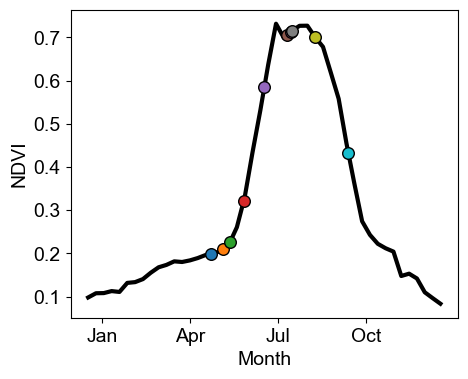

In [6]:
path_ref_evi = open('BC_ref_ndvi.txt')
# path_ref_evi = open('crop_ref_ndvi.txt')
evi_ts_ref = []
for line in path_ref_evi.readlines():
    evi_ts_ref.append(float(line))
evi_ts_ref = np.array(evi_ts_ref)
# print(evi_ts_ref)

path_ref_phe = open('BC_ref_phe.txt')
# path_ref_phe = open('crop_ref_phe.txt')
phe_ref = []
for line in path_ref_phe.readlines():
    phe_ref.append(float(line))
phe_ref = np.array(phe_ref)
# print(phe_ref)

plt.figure(figsize=(5, 4))
plt.plot(DOYs, evi_ts_ref, lw=3, c='k')
plt.xticks(time_xlength_4, time_labels_4, fontproperties=ticks_font)
plt.yticks(fontproperties=ticks_font)
plt.xlabel("Month", fontproperties=ticks_font)
plt.ylabel("NDVI", fontproperties=ticks_font)
for i in range(10):
    plt.scatter(phe_ref[i], np.interp(phe_ref[i], DOYs, evi_ts_ref), c="C{}".format(i), zorder=10, edgecolor='k', s=70)
plt.show()

## 6. Vegetation timeseries preprocessing

First, the vegetation index curve is filtered to reduce the noise of the curve and improve the stability of the phenological extraction results.
We use Chen SG's algorithm to filter the NDVI vegetation index curve.

In [12]:
import sys
sys.path.append("..")
from src.chensg import chen_sg_filter as cf
from src.new_sg import new_sg_filter as nf

In [8]:
from tqdm import tqdm
img_evi_fts = np.copy(img_evi_ts)
xlen, ylen = img_cover.shape
for i in tqdm(range(xlen)):
    for j in range(ylen):
        img_evi_fts[:, i, j] = cf(img_evi_ts[:, i, j])

100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:04<00:00, 35.62it/s]


*Note that the cfilter function is just a simplified version.
Please refer to this link to get original IDL chen sg algorithm:[chen-lab](http://www.chen-lab.club/)*

Next, we can take a look at the smoothed curve.

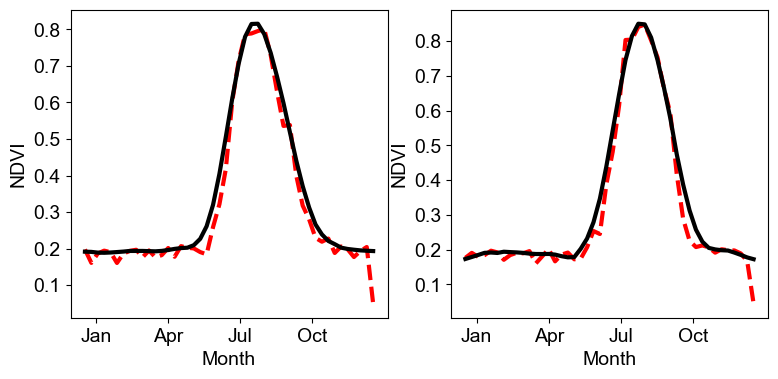

In [15]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
p = random_a_point()
plt.plot(DOYs, img_evi_ts[:, p[0], p[1]], lw=3, c="r", ls='--')
plt.plot(DOYs, img_evi_fts[:, p[0], p[1]], lw=3, c="k", ls='-')

plt.xticks(time_xlength_4, time_labels_4, fontproperties=ticks_font)
plt.yticks(fontproperties=ticks_font)
plt.xlabel("Month", fontproperties=ticks_font)
plt.ylabel("NDVI", fontproperties=ticks_font)

plt.subplot(122)
p = random_a_point()
plt.plot(DOYs, img_evi_ts[:, p[0], p[1]], lw=3, c="r", ls='--')
plt.plot(DOYs, img_evi_fts[:, p[0], p[1]], lw=3, c="k", ls='-')
plt.xticks(time_xlength_4, time_labels_4, fontproperties=ticks_font)
plt.yticks(fontproperties=ticks_font)
plt.xlabel("Month", fontproperties=ticks_font)
plt.ylabel("NDVI", fontproperties=ticks_font)
plt.show()

Obviously, the smoothed curve is more beneficial to obtain phenology.
But in the real phenological extraction, we have to go to the next step, which is to erase both ends of the growing season for all maize curves.
Because theoretically, the front end and the back end represent the vegetation curve changes of other crops.

In [16]:
from scipy.signal import argrelextrema
BREAK_POINTS = (90, 300)
def flatten(curve, doy=DOYs):
    minimal_locs = np.array(argrelextrema(curve, np.less_equal)).reshape(-1)
    locs = np.interp(BREAK_POINTS, doy, np.arange(46))
    first_mini = minimal_locs[np.argmin(np.abs(minimal_locs - locs[0]))]
    second_mini = minimal_locs[np.argmin(np.abs(minimal_locs - locs[1]))]
    curve = np.copy(curve)
    curve[:first_mini] = curve[first_mini]
    curve[second_mini:] = curve[second_mini]
    return curve

img_evi_ffts = np.copy(img_evi_fts)
for i in range(xlen):
    for j in range(ylen):
        if img_cover[i, j]:
            img_evi_ffts[:, i, j] = flatten(img_evi_fts[:, i, j])

Smooth the reference curve.

In [17]:
evi_sts_ref = cf(evi_ts_ref)
evi_fts_ref = flatten(evi_sts_ref)

Draw the filtered vegetation index curve.

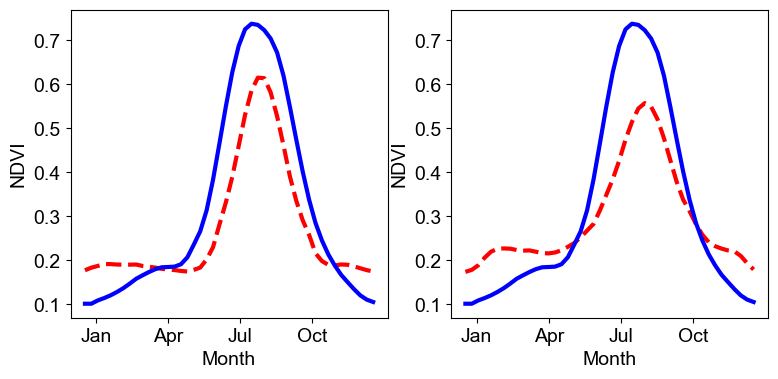

In [18]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
p = random_a_point()
# plt.plot(DOYs, img_evi_ts[:, p[0], p[1]], lw=3, c="r", ls="--")
plt.plot(DOYs, img_evi_fts[:, p[0], p[1]], lw=3, c="r", ls="--")
plt.plot(DOYs, evi_fts_ref , lw=3, c="b", ls="-")
plt.xticks(time_xlength_4, time_labels_4, fontproperties=ticks_font)
plt.yticks(fontproperties=ticks_font)
plt.xlabel("Month", fontproperties=ticks_font)
plt.ylabel("NDVI", fontproperties=ticks_font)

plt.subplot(122)
p = random_a_point()
# plt.plot(DOYs, img_evi_ts[:, p[0], p[1]], lw=3, c="r", ls="--")
plt.plot(DOYs, img_evi_fts[:, p[0], p[1]], lw=3, c="r", ls="--")
plt.plot(DOYs, evi_fts_ref , lw=3, c="b", ls="-")
plt.xticks(time_xlength_4, time_labels_4, fontproperties=ticks_font)
plt.yticks(fontproperties=ticks_font)
plt.xlabel("Month", fontproperties=ticks_font)
plt.ylabel("NDVI", fontproperties=ticks_font)

plt.show()

## 7. Phenology detection

It can be seen that the vegetation index curve after SG filtering is smooth enough to proceed to the next step.
Now, we have prepared all the preliminary work for phenological extraction and can officially start extraction.
Use the following method to call the smf_s function to detect the phenological period.

This may take a little time, depending on your CPU performance.

In [19]:
from importlib import reload
import src.smf_s_class
reload(src.smf_s_class)
from src.smf_s_class import SMFS
img_smfsphes = np.zeros((len(phe_ref), xlen, ylen))

In [20]:
evi_sts_ref = cf(evi_ts_ref)
evi_fts_ref = flatten(evi_sts_ref)

In [30]:
# 目标曲线不展平
img_smfsphes_s = np.zeros((len(phe_ref), xlen, ylen))
tshift_values_s = np.zeros((len(phe_ref), xlen, ylen))
xscale_values_s = np.zeros((len(phe_ref), xlen, ylen))

for phe_i in range(10): 
    smfs_model1 = SMFS(evi_fts_ref, phe_ref[phe_i], DOYs)
    for i in tqdm(range(xlen)):
        for j in range(ylen):
            if not img_cover[i, j]:
                continue
            img_smfsphes_s[phe_i, i, j] = smfs_model1.doit(img_evi_fts[:, i, j])
            # 获取最终时间偏移和缩放因子
            tshift_values_s[phe_i, i, j] = smfs_model1.final_tshift
            xscale_values_s[phe_i, i, j] = smfs_model1.final_xscale


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:02<00:00, 54.33it/s]


In [2]:
Here we show how the shape model fits different phenological periods

SyntaxError: invalid syntax (1423489963.py, line 1)

播种期
参考物候期: 127.0
估算物候期: 156.0
Final tshift: -29.0
Final xscale: 0.9500000000000002


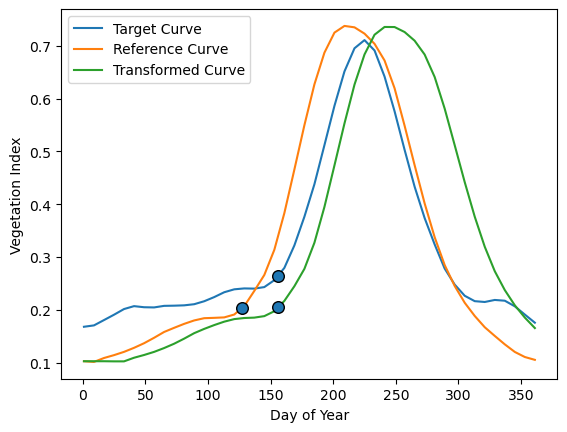

成熟期
参考物候期: 139.0
估算物候期: 160.0
Final tshift: -21.0
Final xscale: 1.2500000000000007


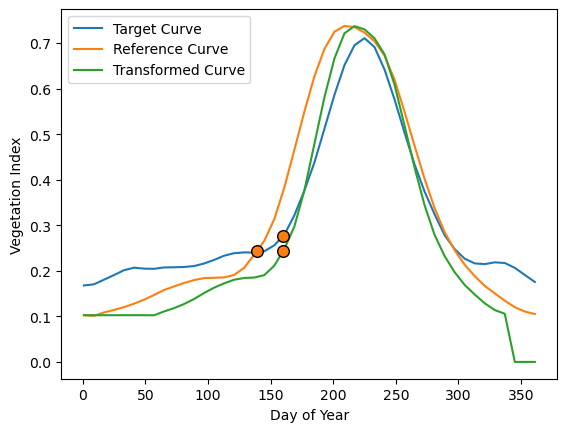

三叶期
参考物候期: 146.0
估算物候期: 167.0
Final tshift: -21.0
Final xscale: 1.1500000000000006


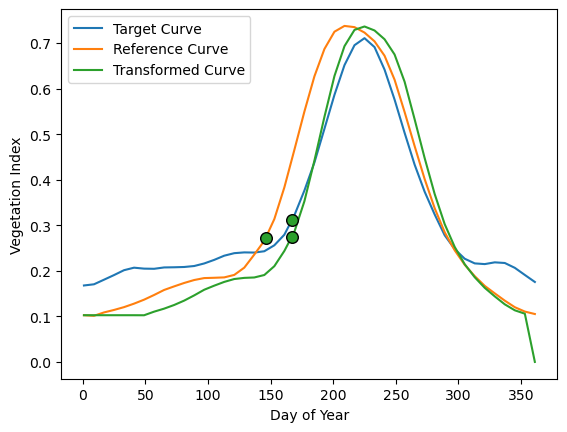

七叶期
参考物候期: 160.0
估算物候期: 181.0
Final tshift: -21.0
Final xscale: 1.0500000000000003


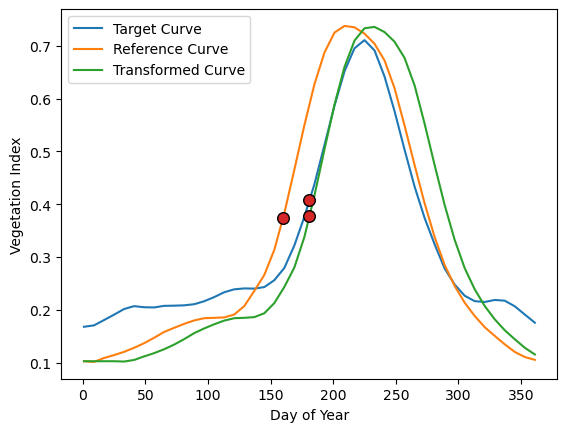

拔节期
参考物候期: 181.0
估算物候期: 199.0
Final tshift: -18.0
Final xscale: 1.1000000000000003


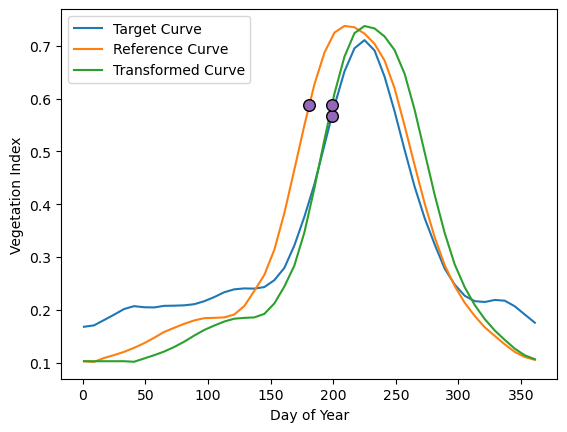

抽穗期
参考物候期: 204.0
估算物候期: 215.0
Final tshift: -11.0
Final xscale: 1.2500000000000007


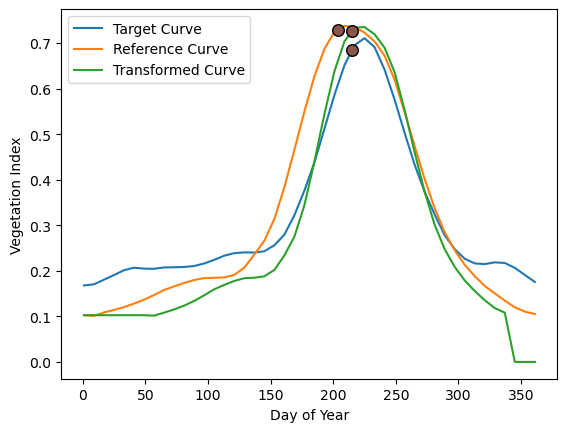

开花期
参考物候期: 208.0
估算物候期: 219.0
Final tshift: -11.0
Final xscale: 1.2500000000000007


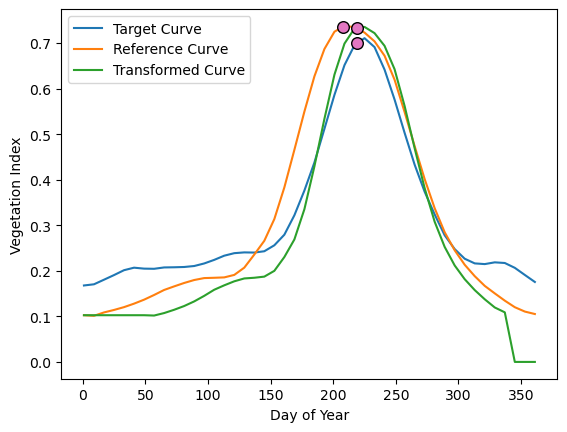

吐丝期
参考物候期: 209.0
估算物候期: 219.0
Final tshift: -10.0
Final xscale: 1.2500000000000007


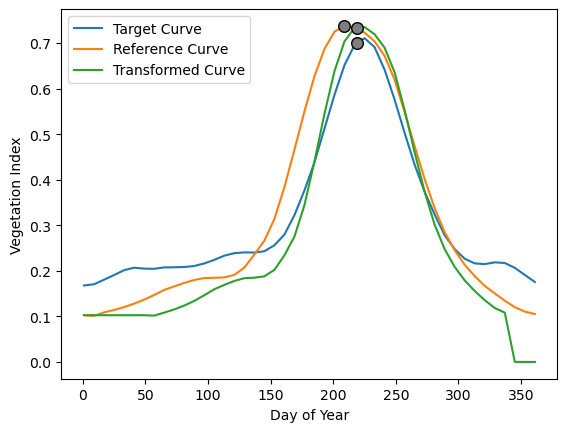

乳熟期
参考物候期: 233.0
估算物候期: 243.0
Final tshift: -10.0
Final xscale: 1.0000000000000002


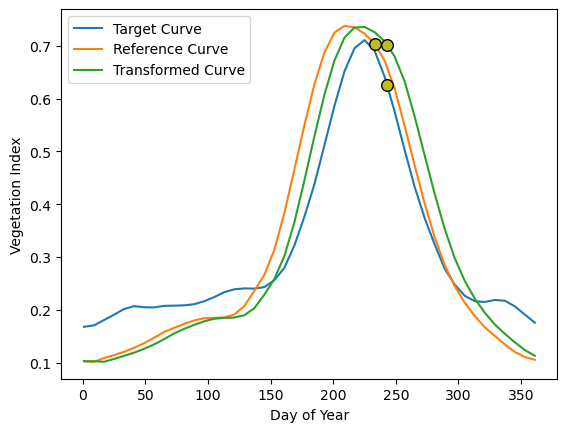

成熟期
参考物候期: 267.0
估算物候期: 261.0
Final tshift: 6.0
Final xscale: 1.2000000000000006


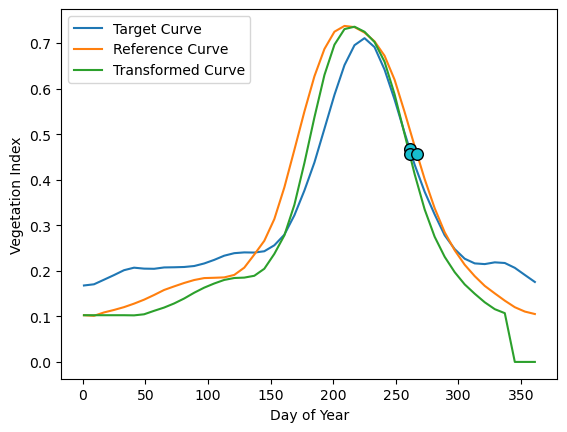

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
test = random_a_point()
# print(test)
DOYs = np.arange(1, 366, 8)
# 定义形状变换函数，并使用 Numba 进行加速
@jit(nopython=True)
def shape_change_faster(t, p0, tshift, xscale, aug_ts, trans_ts):
    '''
    Numba accelerated version of the shape_model_change function.
    :return:
    '''
    t = t * xscale + (1 - xscale) * p0 + tshift * xscale
    for i, t_ in enumerate(t):
        if t_ <= 0:
            t[i] = 0
        if t_ >= 365:
            t[i] = 365
        trans_ts[i] = aug_ts[int(t[i] * 100)]
    return trans_ts

p0, p1 = test[0], test[1]

# 获取目标曲线
target_curve = img_evi_fts[:, p0, p1]
# 增强的时间序列
T_AUG = np.arange(0, 365, 0.01)
REF_VT_AUG = np.interp(T_AUG, DOYs, evi_sts_ref)
phe_title = ['播种期', '成熟期', '三叶期', '七叶期', '拔节期', '抽穗期', '开花期', '吐丝期', '乳熟期', '成熟期']
for k in range(10):
    # 获得最终的时间偏移和缩放因子
    final_tshift = tshift_values_s[k, p0, p1]
    final_xscale = xscale_values_s[k, p0, p1]
    # 形状模型发生改变后的存储数列
    TEMP_TRANS = np.zeros((46, ))
    print(phe_title[k])
    # 直接在绘图代码中实现形状变换逻辑
    re = np.zeros_like(target_curve)
    res = shape_change_faster(DOYs, phe_ref[k], final_tshift, final_xscale, REF_VT_AUG, TEMP_TRANS)
#     print(len(REF_VT_AUG))
    # # 绘制参考曲线和变化后的曲线
    plt.plot(DOYs, target_curve, label='Target Curve')
#     for i in range(10):
#             plt.scatter(phe_ref[i], np.interp(phe_ref[i], DOYs, target_curve), c="C{}".format(i), zorder=10, edgecolor='k', s=70)
    plt.plot(DOYs, evi_sts_ref, label='Reference Curve')
    for i in range(k,k+1):
            plt.scatter(img_smfsphes_s[i, p0, p1], np.interp(img_smfsphes_s[i, p0, p1], DOYs, target_curve), c="C{}".format(i), zorder=10, edgecolor='k', s=70)
            plt.scatter(img_smfsphes_s[i, p0, p1], np.interp(img_smfsphes_s[i, p0, p1], DOYs, res), c="C{}".format(i), zorder=10, edgecolor='k', s=70)
            plt.scatter(phe_ref[i], np.interp(phe_ref[i], DOYs, evi_sts_ref), c="C{}".format(i), zorder=10, edgecolor='k', s=70)
    plt.plot(DOYs, res, label='Transformed Curve')
    plt.xlabel('Day of Year')
    plt.ylabel('Vegetation Index')
    plt.legend()
    # 在绘图代码块中添加输出语句
    print("参考物候期:", phe_ref[k])
    print("估算物候期:",img_smfsphes_s[k, p0, p1])
    print("Final tshift:", final_tshift)
    print("Final xscale:", final_xscale)

    plt.show()



Randomly select some points to see the performance of phenology monitor.

观测物候期: [127. 139. 146. 160. 181. 204. 208. 209. 233. 267.]
****************************************************
估算物候期: [141. 150. 158. 174. 194. 212. 214. 215. 236. 261.]
****************************************************
估算误差值: [14. 11. 12. 14. 13.  8.  6.  6.  3. -6.]
****************************************************
估算物候期: [141. 149. 157. 172. 196. 212. 215. 215. 236. 261.]
****************************************************
估算误差值: [14. 10. 11. 12. 15.  8.  7.  6.  3. -6.]
****************************************************
估算物候期: [141. 150. 157. 168. 188. 205. 209. 209. 234. 258.]
****************************************************
估算误差值: [14. 11. 11.  8.  7.  1.  1.  0.  1. -9.]
****************************************************


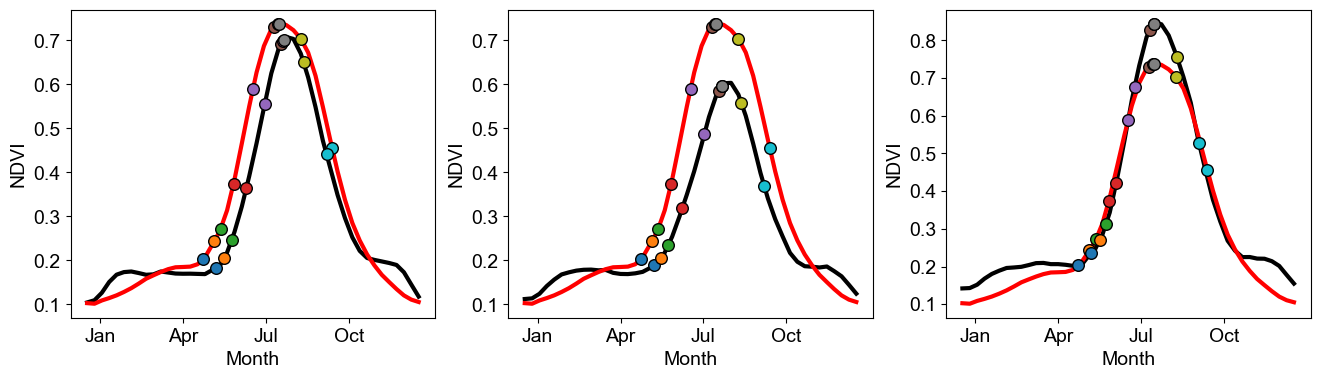

In [33]:
plt.figure(figsize=(16, 4))
phe = [125,135,139,160,186,204,235,257]
print("观测物候期:", phe_ref)
print("****************************************************")
for i_map in range(3):
    plt.subplot(1, 3, i_map + 1)
    p = random_a_point()
    p[0], p[1]
    
#     plt.plot(DOYs, img_evi_ts[:, p[0], p[1]], lw=3, c="r", ls="--")
#     plt.plot(DOYs, img_evi_fts[:, p[0], p[1]], lw=3, c="k", ls="--")
    plt.plot(DOYs, img_evi_fts[:, p[0], p[1]], lw=3, c="k", ls="-")
    phe_detected = img_smfsphes_s[:, p[0], p[1]]
    plt.plot(DOYs, evi_sts_ref, lw=3, c='r')
    for i in range(10):
        plt.scatter(phe_ref[i], np.interp(phe_ref[i], DOYs, evi_sts_ref), c="C{}".format(i), zorder=10, edgecolor='k', s=70)
    print("估算物候期:", img_smfsphes_s[:, p[0], p[1]])
    for i in range(10):
        if phe_detected[i] == 0:
            continue
        plt.scatter(phe_detected[i], 
                    np.interp(phe_detected[i], DOYs, img_evi_ffts[:, p[0], p[1]]),
                    c='C{}'.format(i),
                    s=70,
                    zorder=10,
                    edgecolor='k')
    plt.xticks(time_xlength_4, time_labels_4, fontproperties=ticks_font)
    plt.yticks(fontproperties=ticks_font)
    plt.xlabel("Month", fontproperties=ticks_font)
    plt.ylabel("NDVI", fontproperties=ticks_font)
    print("****************************************************")
    print("估算误差值:", img_smfsphes_s[:, p[0], p[1]] - phe_ref)
    print("****************************************************")
plt.show()

In [32]:
import numpy as np

# 计算均方根误差
def calculate_rmse(observed, reference):
    return np.sqrt(np.nanmean(np.square(observed - reference)))

# 创建一个数组来存储每个物候期的均方根误差
rmse_values = []

for i in range(10):
    # 选择第 i 个物候期的观测值
    observed_values = img_smfsphes_s[i, (img_cover == 1)]
    
    # 计算均方根误差，此时 reference 为 phe_ref[i]
    rmse = round(calculate_rmse(observed_values, phe_ref[i]))
    
    # 将结果添加到数组中
    rmse_values.append(rmse)


# 打印结果
for i in range(10):
    print(rmse_values[i], end = " ")



19 14 13 12 11 6 5 5 5 10 